In [1]:
# Built-in
import os
import itertools
import multiprocessing

# Analysis packages
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==0.24.2 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [2]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

In [3]:
# read in count matrices post nuclei and gene quality control
adata = sc.read(os.path.join(settings.data_path, 'post-wt-clustering.h5ad'))
adata

AnnData object with n_obs × n_vars = 299193 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

# Analyse number of cells per <cluster,drug,time>

In [4]:
combo_cell_counts = adata.obs[['drug', 'leiden', 'time']].copy()
combo_cell_counts['leiden'] = combo_cell_counts['leiden'].astype(int)
combo_cell_counts['count'] = 1
combo_cell_counts = combo_cell_counts.groupby(['drug', 'leiden', 'time']).count()

ket_combo_cell_counts = combo_cell_counts.loc[('Ket'),:].reset_index()
ket_combo_cell_counts = ket_combo_cell_counts.query('time != 0')
ket_combo_cell_counts = ket_combo_cell_counts.query('leiden < 15')

psilo_combo_cell_counts = combo_cell_counts.loc[('Psilo'),:].reset_index()
psilo_combo_cell_counts = psilo_combo_cell_counts.query('time != 0')
psilo_combo_cell_counts = psilo_combo_cell_counts.query('leiden < 15')

ket_combo_cell_counts.dtypes

leiden    int64
time      int64
count     int64
dtype: object

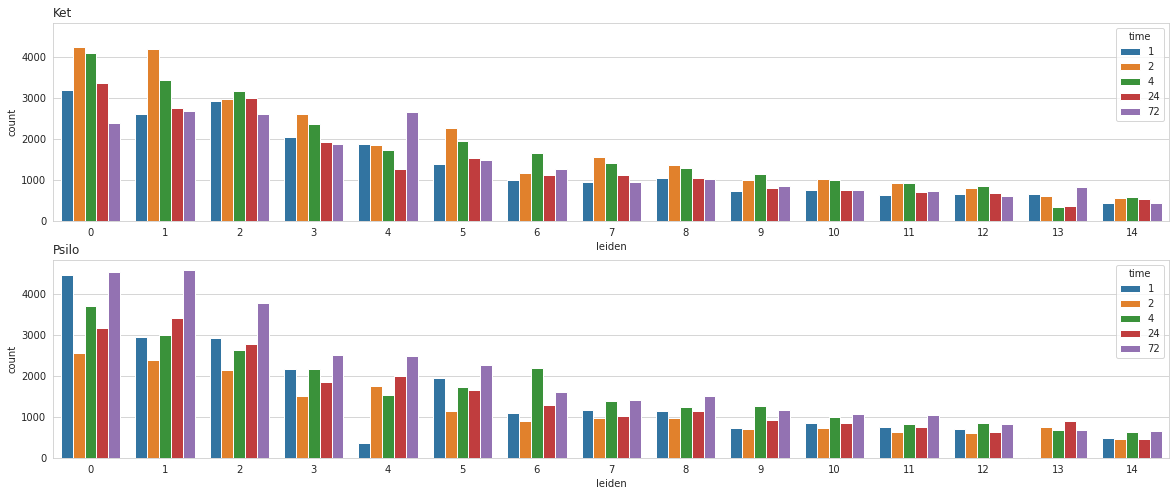

In [5]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(20,8), sharey=True)
g_ket = sns.barplot(
    data = ket_combo_cell_counts, 
    x='leiden', y='count', hue='time',
    ax=axes[0]
)
g_psilo = sns.barplot(
    data = psilo_combo_cell_counts, 
    x='leiden', y='count', hue='time',
    ax=axes[1]
)
g_ket.set_title('Ket', loc='left')
g_psilo.set_title('Psilo', loc='left')
fig.savefig(os.path.join(settings.fig_path, 'num_cells_per_cluster_drug_time.png'))

Subset to the minimum from clusters 0-12, including 11 (even tho we're confused about what it is) but excluding 4.1h

# Subset, subsample, recombine

Also do it twice so we have a replicate

In [13]:
# store adata.uns for later
old_adata_uns = adata.uns

In [14]:
old_adata_uns

OverloadedDict, wrapping:
	{'hvg': {'flavor': 'seurat'}, 'label_colors': array(['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6',
       '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762',
       '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c',
       '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a',
       '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa',
       '#d16100', '#ddefff', '#000035', '#7b4f4b', '#a1c299', '#300018',
       '#0aa6d8', '#013349', '#00846f', '#372101', '#ffb500', '#c2ffed'],
      dtype=object), 'label_colors_dict': {'0h_none_F_346': '#e2e2e2', '0h_none_F_347': '#5f5f5f', '0h_none_F_465': '#404040', '0h_none_F_466': '#b5b5b5', '0h_none_F_467': '#1d1d1d', '0h_none_M_291': '#959595', '0h_none_M_469': '#cecece', '0h_none_M_470': '#7a7a7a', '1h_Ket_F_354': '#73c476', '1h_Ket_F_408': '#40aa5d', '1h_Ket_M_445': '#a0d99b', '1h_Psilo_F_303': '#006c2c', '1h_Psilo_F_352': '#228a44', '1h_Psilo

In [6]:
combo_cell_counts_leiden_topn = combo_cell_counts.query(
"""
leiden <= 12 and \
leiden != 11 and \
not (leiden==4 and time == 1 and drug =='Psilo')
""").reset_index()
combo_cell_counts_leiden_topn = combo_cell_counts_leiden_topn.query('(drug != "none") & (time != 0)')
subsample_target = combo_cell_counts_leiden_topn['count'].min()
subsample_target

595

In [7]:
combo_cell_counts_leiden_topn.query('leiden == 4')

,drug,leiden,time,count
25,Ket,4,1,1870
26,Ket,4,2,1856
27,Ket,4,4,1722
28,Ket,4,24,1251
29,Ket,4,72,2653
97,Psilo,4,2,1746
98,Psilo,4,4,1529
99,Psilo,4,24,1987
100,Psilo,4,72,2479


In [8]:
%%time
n_replicates = 2
subsampled_objects = [ [] for _ in range(n_replicates) ]
for replicate in range(n_replicates):
    num_its_left = combo_cell_counts_leiden_topn.shape[0]
    for _,row in combo_cell_counts_leiden_topn.iterrows():
        if num_its_left % 20 == 0:
            print(f'{num_its_left} combos remaining')
        num_its_left -= 1

        bdata = adata[(adata.obs.leiden == str(row['leiden'])) & 
                      (adata.obs.drug == row['drug']) & 
                      (adata.obs.time == row['time'])].copy()
        sc.pp.subsample(bdata, n_obs=subsample_target)
        subsampled_objects[replicate].append(bdata)

    # final iterations for the none-0hr bc I dropped that from the combo dataframe
    for cluster in combo_cell_counts_leiden_topn['leiden'].unique():
        bdata = adata[(adata.obs.leiden == str(cluster)) & 
                      (adata.obs.drug == 'none') & 
                      (adata.obs.time == 0)].copy()
        sc.pp.subsample(bdata, n_obs=subsample_target)
        subsampled_objects[replicate].append(bdata)

100 combos remaining
80 combos remaining
60 combos remaining
40 combos remaining
20 combos remaining
100 combos remaining
80 combos remaining
60 combos remaining
40 combos remaining
20 combos remaining
CPU times: user 30.8 s, sys: 26 s, total: 56.8 s
Wall time: 57.1 s


In [15]:
%%time
for replicate in range(n_replicates):
    print('Replicate',replicate)
    sdata = ad.concat(subsampled_objects[replicate])
    sdata.uns = old_adata_uns
    sc.pp.calculate_qc_metrics(sdata, percent_top=None, inplace=True)
    sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon',)
    sdata.write(f"treatment-combinations-subsampled-replicate{replicate}.h5ad")

Replicate 0
Replicate 1
CPU times: user 18min 29s, sys: 1min 23s, total: 19min 53s
Wall time: 20min 12s


In [16]:
combo_cell_counts = sdata.obs[['drug', 'leiden', 'time']].copy()
combo_cell_counts['leiden'] = combo_cell_counts['leiden'].astype(int)
combo_cell_counts['count'] = 1
combo_cell_counts = combo_cell_counts.groupby(['drug', 'leiden', 'time']).count()

ket_combo_cell_counts = combo_cell_counts.loc[('Ket'),:].reset_index()
psilo_combo_cell_counts = combo_cell_counts.loc[('Psilo'),:].reset_index()

ket_combo_cell_counts.dtypes

leiden    int64
time      int64
count     int64
dtype: object

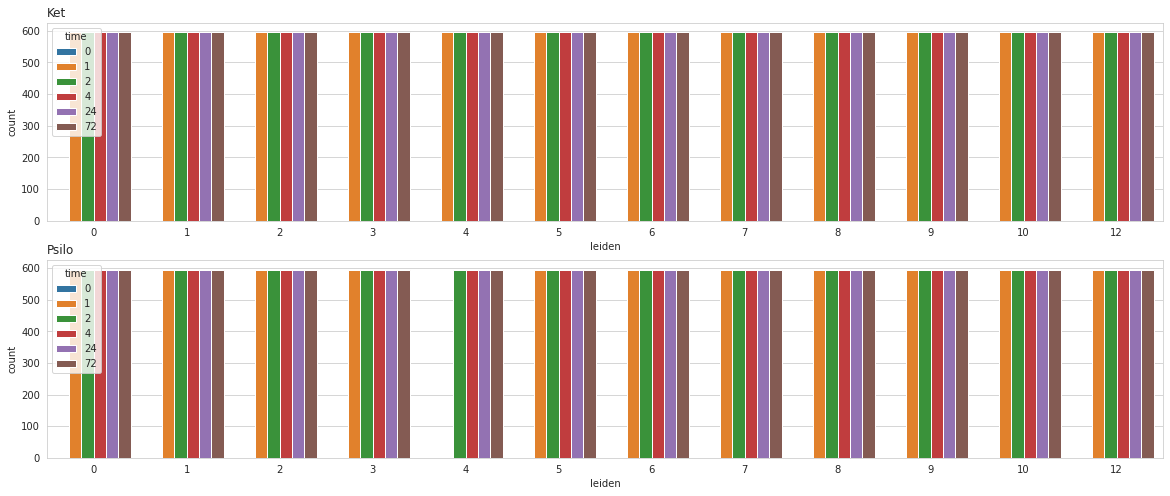

In [17]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(20,8), sharey=True)
g_ket = sns.barplot(
    data = ket_combo_cell_counts, 
    x='leiden', y='count', hue='time',
    ax=axes[0]
)
g_psilo = sns.barplot(
    data = psilo_combo_cell_counts, 
    x='leiden', y='count', hue='time',
    ax=axes[1]
)
g_ket.set_title('Ket', loc='left')
g_psilo.set_title('Psilo', loc='left')
fig.savefig(os.path.join(settings.fig_path, 'subsampled_num_cells_per_cluster_drug_time.png'))

In [18]:
del adata
del bdata